## create lots of room,this is debugging purpose notebook to see wall thickness and intersection while creating wals

In [1]:
from shapely import affinity
import argparse
import cv2
import numpy as np
import math
from pcg_gazebo.simulation.world import ModelGroup
from pcg_gazebo.parsers.sdf import create_sdf_element
# import shutil
from os import listdir, mkdir
import xml.etree.ElementTree as gfg 
import subprocess
import os
from pcg_gazebo.generators.creators import extrude
from pcg_gazebo.generators.shapes import random_points_to_triangulation
# from pcg_gazebo.visualization import plot_shapely_geometry, plot_mesh
from pcg_gazebo.generators import WorldGenerator
from pcg_gazebo.utils import generate_random_string
from numpy import random
from math import pi as PI
from shapely.geometry import Polygon, LineString, Point
from numpy import random
from math import pi as PI

import numpy as np
from matplotlib import pyplot as plt


In [2]:
RAND_MAP_CMD = "random-map"

In [3]:

VERSION = "1.0" 
SDF_VERSION = "1.6"
CONFIG_EMAIL = "onur.demir2@std.yildiz.edu.tr"
CONFIG_AUTHOR_NAME = "Onur Demir"

SINGLE_ROOM_ARG_COUNT = 3

WALL_THICKNESS = 0.15
WALL_HEIGHT = 2

HUSKY_SIZE_X = 1.2#0.98740000
HUSKY_SIZE_Y = 0.9#0.57090000

stat_sign_factor = 1.645

RAND_MAP_CMD = "random-map"

In [4]:

parser = argparse.ArgumentParser(description='Process some integers.')
# parser.add_argument('integers', metavar='N', type=int, nargs='+',
#                     help='an integer for the accumulator')
# parser.add_argument('--sum', dest='accumulate', action='store_const',
#                     const=sum, default=max,
#                     help='sum the integers (default: find the max)')


lastWallSequence = None # static variable of lastWallSequence function

parser.add_argument('--spawn-count', '-r', '--robot-count', type=int ,default=5)
parser.add_argument('--scale-factor', '-s', type=float, default=10.0) # it must be greater than 10 otherwise robot can not move other rooms


parser.add_argument('choice', choices=['single_room', 'multi_room'])

parser.add_argument('room_args', metavar='N', type=int, nargs='+',
                     help='single_room [number of point for triangulation] [min_bound] [max_bound] or multi_room [map_id]')

parser.add_argument('--mesh' ,'-m' , action='store_true', help='distribute random mesh available.')

parser.add_argument('--use-db','-mdb', action='store_true', help='use random mesh from  remote mesh databases')

parser.add_argument('--asset-dir','--asset-dir-path','-dir', type=str, default="/home/onur/building_editor_models/", help='gazebo asset directory path.')
parser.add_argument('--wall-name', '-wn', type=str, default="wall", help='wall name')

parser.add_argument('--box', '-b', type=int, default=3, help='number of box in the map')
parser.add_argument('--cylinder', '-c', type=int, default=3, help='number of cylinder in the map')



args = parser.parse_args("multi_room 17".split())

In [5]:

class HoughBundler:     
    def __init__(self,min_distance=5,min_angle=2):
        self.min_distance = min_distance
        self.min_angle = min_angle
    
    def get_orientation(self, line):
        orientation = math.atan2(abs((line[3] - line[1])), abs((line[2] - line[0])))
        return math.degrees(orientation)

    def check_is_line_different(self, line_1, groups, min_distance_to_merge, min_angle_to_merge):
        for group in groups:
            for line_2 in group:
                if self.get_distance(line_2, line_1) < min_distance_to_merge:
                    orientation_1 = self.get_orientation(line_1)
                    orientation_2 = self.get_orientation(line_2)
                    if abs(orientation_1 - orientation_2) < min_angle_to_merge:
                        group.append(line_1)
                        return False
        return True

    def distance_point_to_line(self, point, line):
        px, py = point
        x1, y1, x2, y2 = line

        def line_magnitude(x1, y1, x2, y2):
            line_magnitude = math.sqrt(math.pow((x2 - x1), 2) + math.pow((y2 - y1), 2))
            return line_magnitude

        lmag = line_magnitude(x1, y1, x2, y2)
        if lmag < 0.00000001:
            distance_point_to_line = 9999
            return distance_point_to_line

        u1 = (((px - x1) * (x2 - x1)) + ((py - y1) * (y2 - y1)))
        u = u1 / (lmag * lmag)

        if (u < 0.00001) or (u > 1):
            #// closest point does not fall within the line segment, take the shorter distance
            #// to an endpoint
            ix = line_magnitude(px, py, x1, y1)
            iy = line_magnitude(px, py, x2, y2)
            if ix > iy:
                distance_point_to_line = iy
            else:
                distance_point_to_line = ix
        else:
            # Intersecting point is on the line, use the formula
            ix = x1 + u * (x2 - x1)
            iy = y1 + u * (y2 - y1)
            distance_point_to_line = line_magnitude(px, py, ix, iy)

        return distance_point_to_line

    def get_distance(self, a_line, b_line):
        dist1 = self.distance_point_to_line(a_line[:2], b_line)
        dist2 = self.distance_point_to_line(a_line[2:], b_line)
        dist3 = self.distance_point_to_line(b_line[:2], a_line)
        dist4 = self.distance_point_to_line(b_line[2:], a_line)

        return min(dist1, dist2, dist3, dist4)

    def merge_lines_into_groups(self, lines):
        groups = []  # all lines groups are here
        # first line will create new group every time
        groups.append([lines[0]])
        # if line is different from existing gropus, create a new group
        for line_new in lines[1:]:
            if self.check_is_line_different(line_new, groups, self.min_distance, self.min_angle):
                groups.append([line_new])

        return groups

    def merge_line_segments(self, lines):
        orientation = self.get_orientation(lines[0])
      
        if(len(lines) == 1):
            return np.block([[lines[0][:2], lines[0][2:]]])

        points = []
        for line in lines:
            points.append(line[:2])
            points.append(line[2:])
        if 45 < orientation <= 90:
            #sort by y
            points = sorted(points, key=lambda point: point[1])
        else:
            #sort by x
            points = sorted(points, key=lambda point: point[0])

        return np.block([[points[0],points[-1]]])

    def process_lines(self, lines):
        lines_horizontal  = []
        lines_vertical  = []
  
        for line_i in [l[0] for l in lines]:
            orientation = self.get_orientation(line_i)
            # if vertical
            if 45 < orientation <= 90:
                lines_vertical.append(line_i)
            else:
                lines_horizontal.append(line_i)

        lines_vertical  = sorted(lines_vertical , key=lambda line: line[1])
        lines_horizontal  = sorted(lines_horizontal , key=lambda line: line[0])
        merged_lines_all = []

        # for each cluster in vertical and horizantal lines leave only one line
        for i in [lines_horizontal, lines_vertical]:
            if len(i) > 0:
                groups = self.merge_lines_into_groups(i)
                merged_lines = []
                for group in groups:
                    merged_lines.append(self.merge_line_segments(group))
                merged_lines_all.extend(merged_lines)
                    
        return np.asarray(merged_lines_all)


In [20]:

def checkMultiRoomIntersection(lines, scale_factor, polygon):

    for j, line in enumerate(lines):
        line = line[0]
        # x_diff = (line[0] - line[2]) * scale_factor
        # y_diff = (line[1] - line[3]) * scale_factor
        
        # yaw_line = math.atan2(y_diff, x_diff)
        # angle = yaw_line
        # x = 0
        # y = WALL_THICKNESS / 2
        # # Rotation matrix multiplication to get rotated x & y
        # xr = (x * math.cos(angle)) - (y * math.sin(angle))
        # yr = (x * math.sin(angle)) + (y * math.cos(angle))

        # line = Polygon(
        # (
        #     (line[0] * scale_factor-xr, line[1] * scale_factor-yr, 0),
        #     (line[0] * scale_factor-xr, line[1] * scale_factor+yr, 0),
        #     (line[2] * scale_factor+xr, line[3] * scale_factor+yr, 0),
        #     (line[2] * scale_factor+xr, line[3] * scale_factor-yr, 0)
        # )
        # )

        line = LineString([Point(line[0] * scale_factor, line[1] * scale_factor), Point(line[2] * scale_factor, line[3] * scale_factor)])
        line = line.buffer(WALL_THICKNESS + 0.15)
        intersects=polygon.intersects(line)

        if(intersects):
            return True

    return False

In [6]:
def createFactoryEngine():
    world_gen = WorldGenerator()
    world_gen.init()
    world_gen.engines.reset()
    return world_gen

In [7]:
def detectHoughLines(image, threshold=5, minLineLength = 5, maxLineGap=5 , rho=1):
 
    # threshold=5#80
    # minLineLength=5#30
    # maxLineGap=10
    # rho=1
    # Grayscale and Canny Edges extracted


    #edges = cv2.Canny(gray, 100, 170, apertureSize = 3)
    # Grayscale and Canny Edges extracted
    edgesY = cv2.Sobel(image, ddepth=cv2.CV_64F, dx=0, dy=1, ksize=5)
    edgesX = cv2.Sobel(image, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=5)
    logical_x = np.logical_or(edgesX<0 , edgesX >0)
    logical_y = np.logical_or(edgesY<0 , edgesY >0)
    edges = np.logical_or(logical_x, logical_y)

    edges = np.uint8(edges)
    edges = edges * 255
    # Again we use the same rho and theta accuracies
    # However, we specific a minimum vote (pts along line) of 100
    # and Min line length of 3 pixels and max gap between lines of 25 pixels
    lines = cv2.HoughLinesP(edges, rho=rho, theta=np.pi / 180, threshold=threshold, minLineLength=minLineLength, maxLineGap=maxLineGap)

    # lines = cv2.HoughLinesP(edges, rho=rho, theta=np.pi / 180, threshold=threshold, minLineLength=minLineLength, maxLineGap=maxLineGap)
    bundler = HoughBundler(min_distance=10,min_angle=5)
    lines = bundler.process_lines(lines)

    return lines

In [8]:
def add_wall(walls_model, wall_param, width, height, wall_name='Wall') :

    box = create_sdf_element('box')
    box.size = [wall_param['dist'], width, height]
    collision = create_sdf_element('collision')
    collision.geometry.box = box
    visual = create_sdf_element('visual')
    visual.geometry.box = box
    walls_model.add_link(wall_name)
    link = walls_model.get_link_by_name(wall_name)
    link.collision = collision
    link.visual = visual
    link.pose = [wall_param['x'], wall_param['y'], wall_param['z'], wall_param['roll'],wall_param['pitch'],wall_param['yaw']]
    link.add_collision(name="collision", collision=collision)
    link.add_visual(name="visual", visual=visual)
    
    return walls_model


In [9]:
def lastWallSequenceInAsset():
    global lastWallSequence
    if lastWallSequence == None: 
        list_dir = listdir(args.asset_dir)
        if(len(list_dir) == 0) :
            lastWallSequence = 0
            return 0
        
        list_dir = [os.path.join(args.asset_dir, f) for f in list_dir]
        list_dir.sort(key=lambda x: os.path.getmtime(x))
        number = "".join([i for i in list_dir[-1] if i.isdigit() and int(i) < 10 and int(i) > -1 ])
        
        if(number==""):
            lastWallSequence = 0
            return 0
        
        lastWallSequence = int(number) 
    return lastWallSequence


In [10]:
def createGazeboAssetModelConfig():
    path = args.asset_dir
    root = gfg.Element("model")

    print("asset model is creating for folder " + path)

    name = gfg.Element("name")
    last_wall_seq = lastWallSequenceInAsset()
    name.text = args.wall_name + (str(int(last_wall_seq)+1) if last_wall_seq != None else "1")
    path = path+name.text + "/"
    mkdir(path)

    print("wall model name is " + name.text)


    root.append (name)
        
    version = gfg.Element("version")
    version.text = VERSION
    root.append(version)

    sdf = gfg.Element("sdf")
    sdf.text = "model.sdf"
    sdf.set("version",SDF_VERSION)
    root.append(sdf)

    author = gfg.Element("author")

    a_name = gfg.SubElement(author, "name")
    a_name.text = CONFIG_AUTHOR_NAME
    a_email = gfg.SubElement(author, "email")
    a_email.text = CONFIG_EMAIL

    description = gfg.Element("description")
    description.text = "Auto generated maps."

    root.append(author)
    root.append(description)

    model_sdf_path = path + "model.config"
    f = open(model_sdf_path, "w")
    
    f.write(gfg.tostring(root, encoding='unicode'))
    f.close()

    return path

In [18]:
def removeIf(list, value):
    if list.count(value) > 0 : 
        list.remove(value)
    return list



def createRandomRobotPolygonInMap(centroid, bounds):
    rand_x_left = random.normal(centroid.x, abs(bounds[0] - centroid.x)/stat_sign_factor )
    rand_x_right = random.normal(centroid.x, abs(bounds[2] - centroid.x)/stat_sign_factor )
    rand_x = (rand_x_left + rand_x_right) / 2

    rand_y_left = random.normal(centroid.y, abs(bounds[1] - centroid.y)/stat_sign_factor )
    rand_y_right = random.normal(centroid.y, abs(bounds[3] - centroid.y)/stat_sign_factor )
    rand_y = (rand_y_left + rand_y_right) / 2

    rand_yaw=random.uniform(-PI,PI)

    dist_bound_x = HUSKY_SIZE_X / 2
    dist_bound_y = HUSKY_SIZE_Y / 2 

    coord = (
    (rand_x - dist_bound_x, rand_y-dist_bound_y ),
    (rand_x - dist_bound_x, rand_y+dist_bound_y ),
    (rand_x + dist_bound_x, rand_y+dist_bound_y),
    (rand_x + dist_bound_x, rand_y-dist_bound_y) ) 
    polygon = Polygon(coord)

    
    # Rotate 30 degrees CCW from origin at the center of bbox
    polygon = affinity.rotate(polygon, np.rad2deg(rand_yaw), 'center')
    print(polygon)
    position_tuple = (rand_x, rand_y, rand_yaw)
    return polygon, position_tuple

def checkRandomRobotPosition(wall_model_shapely, robotPolygon):
    return wall_model_shapely.contains(robotPolygon)

def add_assets(world_gen):

    world_gen.add_asset(
        tag='static_box',
        description=dict(
            type='box',
            args=dict(
                size="5 * __import__('pcg_gazebo').random.rand(3)",
                name='cuboid',
                mass="max(0.1, __import__('pcg_gazebo').random.rand())",
                color='xkcd'
            )
        )
    )
    world_gen.add_asset(
    tag='static_cylinder',
    description=dict(
        type='cylinder',
        args=dict(
            length="2 * __import__('pcg_gazebo').random.rand()",
            radius="2 * __import__('pcg_gazebo').random.rand()",
            name='cylinder',
            color='xkcd'
        )
        )
    )
    print('Asset is available for world generation(static_cylinder,static_box)=', 'static_cylinder' in world_gen.assets.tags , 'static_box' in world_gen.assets.tags)


In [12]:
def imshow(title = "Image", image = None, size = 10):
    w, h = image.shape[0], image.shape[1]
    aspect_ratio = w/h
    plt.figure(figsize=(size * aspect_ratio,size))
    plt.imshow(image)
    plt.title(title)
    plt.show()

In [13]:
__file__ = os.getcwd()
__file__

'/home/onur/2D-lidar-RCnn-Ros/husky_sim/src/map_creator_script'

starting random map creation...
b'Random Map Generator
Settings:
Map Id: 17
/home/onur/2D-lidar-RCnn-Ros/husky_sim/src/map_creator_script/nav2_random_map_generator/random_world/media/materials/texture/random_world.png


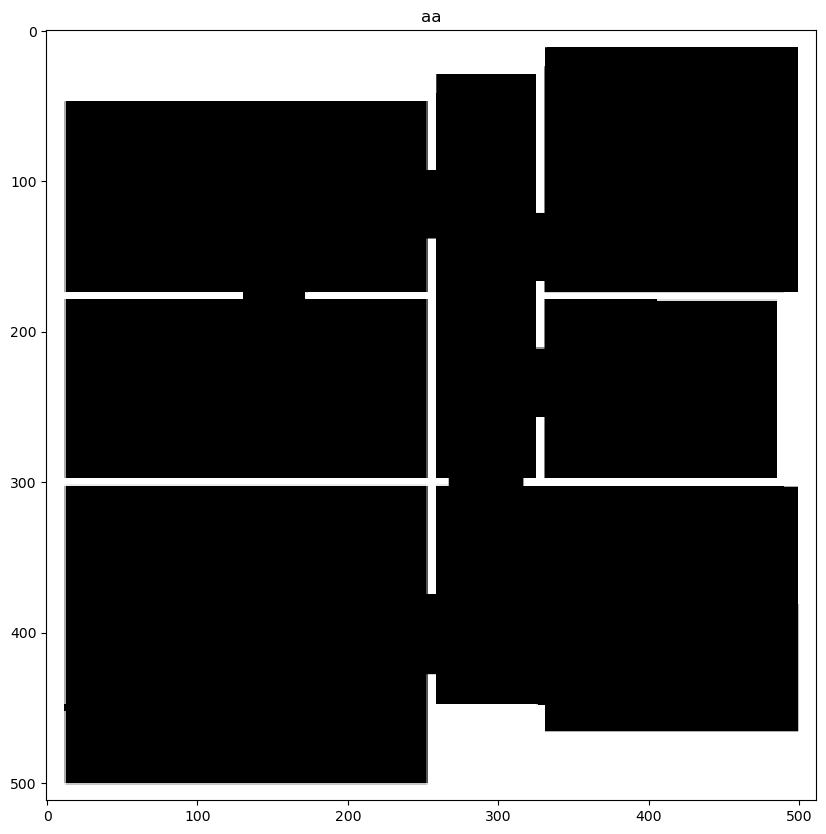

In [14]:
print("starting random map creation...")
py_path = __file__
# print(py_path)
# print(py_path+'/nav2_random_map_generator/src')
# os.chdir(py_path+'/nav2_random_map_generator/src')
p_image = subprocess.Popen("./" + RAND_MAP_CMD + " " + str(args.room_args[0])+" 0 0 5 512 512 0 0 0 0 0 0", cwd=py_path+"/nav2_random_map_generator/src", stdout=subprocess.PIPE, shell=True)

# p_image.wait()
out, err = p_image.communicate()

print("\n".join(str(out).split('\\n')[0:3]))

# p_image.wait()

print(py_path + '/nav2_random_map_generator/random_world/media/materials/texture/random_world.png')

image = cv2.imread(py_path + '/nav2_random_map_generator/random_world/media/materials/texture/random_world.png')
imshow("aa",image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

lines = detectHoughLines(image)


In [15]:
image

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [16]:
min_len_map=min(image.shape[0:1])
scale_factor = 1/(min_len_map/args.scale_factor)

wall_sdf_ = create_sdf_element('sdf')
walls_model = create_sdf_element('model')
walls_model.static = True
walls_model.allow_auto_disable = True

for i,line in enumerate(lines):
    line = line[0]
    x_cent = ((line[0] + line[2]) / 2) * scale_factor
    y_cent = ((line[1] + line[3]) / 2) * scale_factor
    x_diff = (line[2] - line[0]) * scale_factor
    y_diff = (line[3] - line[1]) * scale_factor
    dist = math.sqrt(x_diff * x_diff + y_diff * y_diff)
    yaw = math.atan2(y_diff, x_diff)
    pitch = 0
    roll = 0
    wall_param={'x': x_cent, 'y': y_cent,'z':0, 'dist': dist, 'yaw': yaw, 'pitch': pitch,'roll': roll}
    walls_model = add_wall(walls_model, wall_param, wall_name='Wall_' + str(i), width=WALL_THICKNESS, height=WALL_HEIGHT)


    

In [19]:

path = createGazeboAssetModelConfig()

last_wall_seq = lastWallSequenceInAsset()
walls_model_name = "walls" + (str(int(last_wall_seq)+1) if last_wall_seq != None else "1")
wall_sdf_.add_model(walls_model_name, walls_model)
wall_sdf_.export_xml(path +  "/model.sdf")

walls_model=ModelGroup.from_sdf(wall_sdf_)

world_gen = None
if args.mesh:
    world_gen = createFactoryEngine()

    model_w_polygon = walls_model.models[walls_model_name].get_footprint()
    model_w_polygon_free_space=model_w_polygon[walls_model_name]
    walls_model = extrude(
        polygon=model_w_polygon_free_space,
        thickness=0.20,
        height=2,
        pose=[0, 0, 1 , 0, 0, 0],
        extrude_boundaries=True,
        color='xkcd')
    walls_model.name = 'walls'

    world_gen.add_constraint(
        name='room_workspace',
        type='workspace',
        frame='world',
        geometry_type='polygon',
        polygon=model_w_polygon_free_space
    )
    
    world_gen.add_constraint(
        name='tangent_to_ground_plane',
        type='tangent',
        frame='world',
        reference=dict(
            type='plane',
            args=dict(
                origin=[0, 0, 0],
                normal=[0, 0, 1]
            )
        )
    )

    add_assets(world_gen)


    NUM_BOXES = args.box
    NUM_CYLINDER = args.cylinder

    placement_policy = dict(
        models=['static_box', 'static_cylinder'],
        config=[
            dict(
                dofs=['x', 'y'],            
                tag='workspace',
                workspace='room_workspace'
            ),
            dict(
                dofs=['yaw'],            
                tag='uniform',                            
                min=-3.141592653589793,
                max=3.141592653589793               
            )
        ]
    )

    world_gen.add_engine(
        tag=generate_random_string(5),
        engine_name='random_pose',
        models=['static_box', 'static_cylinder'],
        max_num=dict(
            static_box=NUM_BOXES,
            static_cylinder=NUM_CYLINDER),
        model_picker='random',
        no_collision=True,
        policies=[placement_policy],
        constraints=[
            dict(
                model='static_box',
                constraint='tangent_to_ground_plane'),
            dict(
                model='static_cylinder',
                constraint='tangent_to_ground_plane')
        ]
    )

    world_gen.run_engines(attach_models=True)

bounds_l = walls_model.get_bounds()
bounds = (bounds_l[0][0], bounds_l[0][1], bounds_l[1][0], bounds_l[1][1] )
centroid = lambda: 0 # struct of x and y with centroid (anonymous class)
centroid.x = (bounds_l[0][0] +  bounds_l[1][0]) / 2
centroid.y = (bounds_l[0][1] +  bounds_l[1][1]) / 2

asset model is creating for folder /home/onur/building_editor_models/


FileExistsError: [Errno 17] File exists: '/home/onur/building_editor_models/wall2/'

In [ ]:
world_gen.world.create_scene().show()

AttributeError: 'NoneType' object has no attribute 'world'

In [ ]:
sub_models = sorted(world_gen.world.models)
sub_models = removeIf(sub_models, 'walls/walls_model')
sub_models = removeIf(sub_models, 'robot')
sub_models = removeIf(sub_models, 'ground_plane')

NameError: name 'world_gen' is not defined

In [56]:
if(world_gen == None): 
    for i in range(args.spawn_count):
        polygon, robot_pos_yaw = createRandomRobotPolygonInMap(centroid, bounds)
        while(checkMultiRoomIntersection( lines, scale_factor, polygon)):
            polygon, robot_pos_yaw = createRandomRobotPolygonInMap(centroid, bounds)


        robot_file=open(path + '/robot_position_'+str(i), 'w')
        robot_file.write(" ".join(map(str,robot_pos_yaw)))
        robot_file.close()


AttributeError: 'NoneType' object has no attribute 'world'

'/home/onur/building_editor_models/'